In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from scipy.io import loadmat
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import Xception
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow_addons as tfa
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# **Converting image into numpy arrays**




In [ ]:
# Paths of train, test and validation image data
train_path = '/content/drive/MyDrive/PennFudanPed/Train'
test_path = '/content/drive/MyDrive/PennFudanPed/Test'
validation_path = '/content/drive/MyDrive/PennFudanPed/Validation'

In [ ]:
# creating a empty list and iterating over every files in image folder and converting them into array and appending them in the created list.
train_images = []
for filename in sorted(os.listdir(train_path)):
    train_image_fullpath = os.path.join(train_path, filename)
    train_img = load_img(train_image_fullpath, target_size=(224,224)) #default input size of the vgg models = (224,224)
    train_img_arr = img_to_array(train_img)
    train_images.append(train_img_arr)

# Converting list into numpy arrays
train_images = np.array(train_images)

In [ ]:
# creating a empty list and iterating over every files in image folder and converting them into array and appending them in the created list.
val_images = []
for filename in sorted(os.listdir(validation_path)):
    val_image_fullpath = os.path.join(validation_path, filename)
    val_img = load_img(val_image_fullpath, target_size=(224,224)) #default input size of the vgg models = (224,224)
    val_img_arr = img_to_array(val_img)
    val_images.append(val_img_arr)
  
# Converting list into numpy arrays
val_images = np.array(val_images)

In [ ]:
# creating a empty list and iterating over every files in image folder and converting them into array and appending them in the created list.

test_images = []
for filename in sorted(os.listdir(test_path)):
    test_image_fullpath = os.path.join(test_path, filename)
    test_img = load_img(test_image_fullpath, target_size=(224,224)) #default input size of the vgg models = (224,224)
    test_img_arr = img_to_array(test_img)
    test_images.append(test_img_arr)

# Converting list into numpy arrays
test_images = np.array(test_images)

# **Storing the bb coordinates in numpy arrays(target)**

In [ ]:
# Paths of train, test and validation bounding box coordinates
train_path1 = '/content/drive/MyDrive/PennFudanPed/anno/Train'
test_path1 = '/content/drive/MyDrive/PennFudanPed/anno/Test'
validation_path1 = '/content/drive/MyDrive/PennFudanPed/anno/Validation'

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
# tree = ET.parse('/kaggle/input/ship-detection/annotations/boat4.xml')
# root = tree.getroot()

# sample_annotations = []

# for neighbor in root.iter('bndbox'):
#     xmin = int(neighbor.find('xmin').text)
#     ymin = int(neighbor.find('ymin').text)
#     xmax = int(neighbor.find('xmax').text)
#     ymax = int(neighbor.find('ymax').text)
    
# #     print(xmin, ymin, xmax, ymax)
#     sample_annotations.append([xmin, ymin, xmax, ymax])

In [ ]:
# Creating a empty list and iterating over bb coordinates and appending them in the list.
train_targets = []
for filename in sorted(os.listdir(train_path1)):
  train_image_fullpath = os.path.join(train_path1, filename)
  tree=ET.parse(train_image_fullpath)
  root=tree.getroot()
  for neighbor in root.iter('bndbox'):
    xmin = int(neighbor.find('xmin').text)
    ymin = int(neighbor.find('ymin').text)
    xmax = int(neighbor.find('xmax').text)
    ymax = int(neighbor.find('ymax').text)
  train_targets.append((xmin,ymin,xmax,ymax))

# Converting list into numpy array
train_targets = np.array(train_targets)

In [ ]:
# Creating a empty list and iterating over bb coordinates and appending them in the list.
val_targets = []
for filename in sorted(os.listdir(validation_path1)):
  val_image_fullpath = os.path.join(validation_path1, filename)
  tree=ET.parse(val_image_fullpath)
  root=tree.getroot()
  for neighbor in root.iter('bndbox'):
    xmin = int(neighbor.find('xmin').text)
    ymin = int(neighbor.find('ymin').text)
    xmax = int(neighbor.find('xmax').text)
    ymax = int(neighbor.find('ymax').text)
  val_targets.append((xmin,ymin,xmax,ymax))
# Converting list into numpy array
val_targets = np.array(val_targets)

In [ ]:
val_targets

In [ ]:
# Creating a empty list and iterating over bb coordinates and appending them in the list.
test_targets = []
for filename in sorted(os.listdir(test_path1)):
  test_image_fullpath = os.path.join(test_path1, filename)
  tree=ET.parse(test_image_fullpath)
  root=tree.getroot()
  for neighbor in root.iter('bndbox'):
    xmin = int(neighbor.find('xmin').text)
    ymin = int(neighbor.find('ymin').text)
    xmax = int(neighbor.find('xmax').text)
    ymax = int(neighbor.find('ymax').text)
  test_targets.append((xmin,ymin,xmax,ymax))

# Converting list into numpy array
test_targets = np.array(test_targets)

# **VGG 19**

In [ ]:
#default input size of the vgg models = (224,224)
image_size = [224,224]

#Loading the pretrained vgg19 model(pretrained on imagenet dataset) from keras
vgg19 = VGG19(input_shape=image_size+[3], weights = 'imagenet', include_top = False)

#Freezing the top layers in the model
for layer in vgg19.layers:
   layer.trainable = False

# Building the custom layers for bb regression on top of vgg19 model
out = vgg19.output
flat = Flatten()(out)
FCL1 = Dense(128,activation = 'relu')(flat)
FCL2 = Dense(32,activation = 'relu')(FCL1)
Out = Dense(4)(FCL2)
model = Model(inputs = vgg19.input, outputs = Out)

# Using Mean Squared Error loss and General Intersection over Union metric for the model.
model.compile(
    loss = tensorflow.keras.losses.MSE,
    optimizer = 'adam',
    metrics = [tfa.losses.GIoULoss()]
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Train the model for 20 epochs
trained_model = model.fit(train_images, train_targets,
             validation_data=(val_images, val_targets),
             batch_size=len(train_images),
             epochs=100,
             shuffle=True,
             verbose=1)

Epoch 1/100
1/1 [==============================] - 1s 838ms/step - loss: 1887.3757 - giou_loss: 0.5343 - val_loss: 11940.6934 - val_giou_loss: 1.1002
Epoch 2/100
1/1 [==============================] - 1s 728ms/step - loss: 1777.8948 - giou_loss: 0.5634 - val_loss: 11489.6699 - val_giou_loss: 1.1055
Epoch 3/100
1/1 [==============================] - 1s 649ms/step - loss: 1575.1813 - giou_loss: 0.5646 - val_loss: 11142.9424 - val_giou_loss: 1.1043
Epoch 4/100
1/1 [==============================] - 1s 666ms/step - loss: 1283.2886 - giou_loss: 0.5281 - val_loss: 10914.8691 - val_giou_loss: 1.0883
Epoch 5/100
1/1 [==============================] - 1s 657ms/step - loss: 975.7549 - giou_loss: 0.4677 - val_loss: 10724.2783 - val_giou_loss: 1.0603
Epoch 6/100
1/1 [==============================] - 1s 650ms/step - loss: 721.3900 - giou_loss: 0.4113 - val_loss: 10454.6201 - val_giou_loss: 1.0333
Epoch 7/100
1/1 [==============================] - 1s 656ms/step - loss: 528.0861 - giou_loss: 0.3616 

# **Code to save and load the model**

In [ ]:
from tensorflow.keras.models import load_model
# model.save('/content/drive/MyDrive/PennFudanPed/model_vg19.h5')
model = load_model('/content/drive/MyDrive/PennFudanPed/model_vg19.h5')

Checking the prediction for random data in 

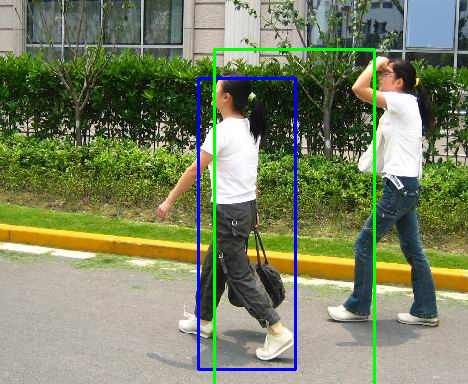

-1

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# test_img=load_img('/content/drive/MyDrive/PennFudanPed/Test/IMG20220324205659.jpg',target_size=(224,224))
y_pred = model.predict(test_images)
m = y_pred[1]
n = test_targets[1]
image = cv2.imread('/content/drive/MyDrive/PennFudanPed/Test/FudanPed00012.png')
cv2.rectangle(image, (n[0],n[1]), (n[2],n[3]), (255,0,0), 2)
cv2.rectangle(image, (m[0],m[1]), (m[2],m[3]), (0,255,0), 2)
cv2_imshow(image)
cv2.waitKey(0)
# predicted green
# actual blue

In [ ]:
test_images[0]

In [ ]:
image = cv2.imread('/content/drive/MyDrive/PennFudanPed/Test/IMG20220324205659.jpg')
# cv2.rectangle(image, (n[0],n[1]), (n[2],n[3]), (255,0,0), 2)
cv2.rectangle(image, (m[0]*13.71,m[1]*18.28), (m[2]*13.71,m[3]*18.28, (0,255,0), 2)


In [ ]:
cv2_imshow(image)
cv2.waitKey(0)

In [ ]:
image = cv2.imread('/content/drive/MyDrive/PennFudanPed/Test/FudanPed00011.png')
n = test_targets[0]
cv2.rectangle(image, (n[0],n[1]), (n[2],n[3]), (255,0,0), 2)

cv2_imshow(image)
cv2.waitKey(0)

In [ ]:
# trained_model = model.fit(train_images, train_targets,
#              validation_data=(val_images, val_targets),
#              batch_size=4,
#              epochs=20,
#              shuffle=True,
#              verbose=1)